In [1]:
# directory making
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set file permissions

#Download the dataset using Kaggle API
!kaggle datasets download -d rohit265/loan-approval-dataset

# Extract the dataset
import zipfile
import os

dataset_zip = "loan-approval-dataset.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("loan_approval_data")  # Extracting to a folder

# Check extracted files
os.listdir("loan_approval_data")

The syntax of the command is incorrect.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


Dataset URL: https://www.kaggle.com/datasets/rohit265/loan-approval-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
loan-approval-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


['.ipynb_checkpoints', '.kaggle', 'kaggle.json', 'loan_approval_dataset.json']

In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
import joblib
import ipywidgets as widgets
from IPython.display import display, HTML

import warnings
warnings.filterwarnings("ignore")



In [5]:
# Load JSON data
file_path = 'loan_approval_dataset.json'

df = pd.read_json(file_path)

# Display basic information
display(df.head()) 


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [8]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 26.9+ MB


None

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values in Each Column:\n")
print(missing_values)

Missing Values in Each Column:

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64


In [7]:
# Encode categorical variables
categorical_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
le_dict = {}
original_categories = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Store encoders for later use
    original_categories[col] = dict(enumerate(le.classes_))  # Store mapping for labels

In [9]:
# Define X before using it
X = df.drop(columns=['Id', 'Risk_Flag', 'CITY', 'STATE'], errors='ignore') # Define X here

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols]) # Now X is defined

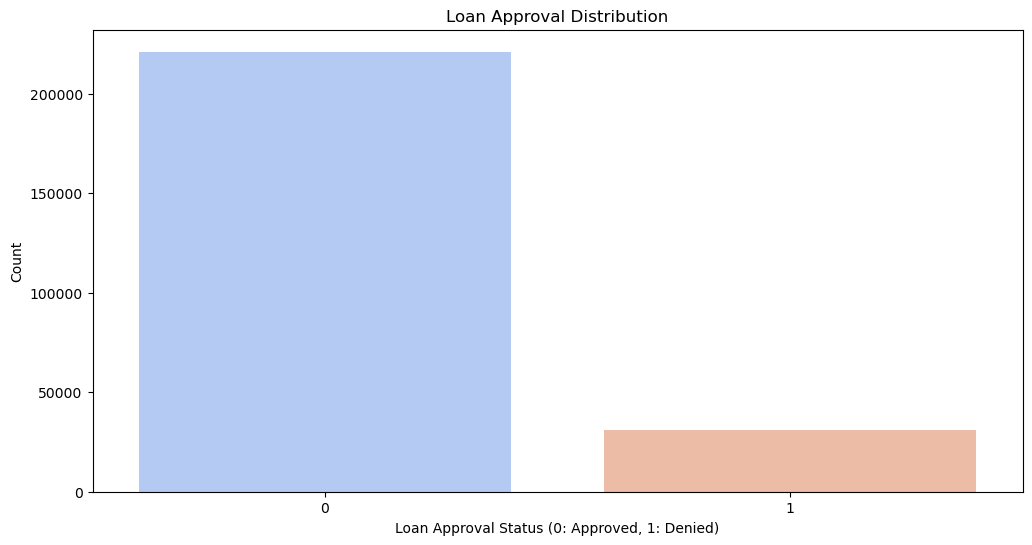

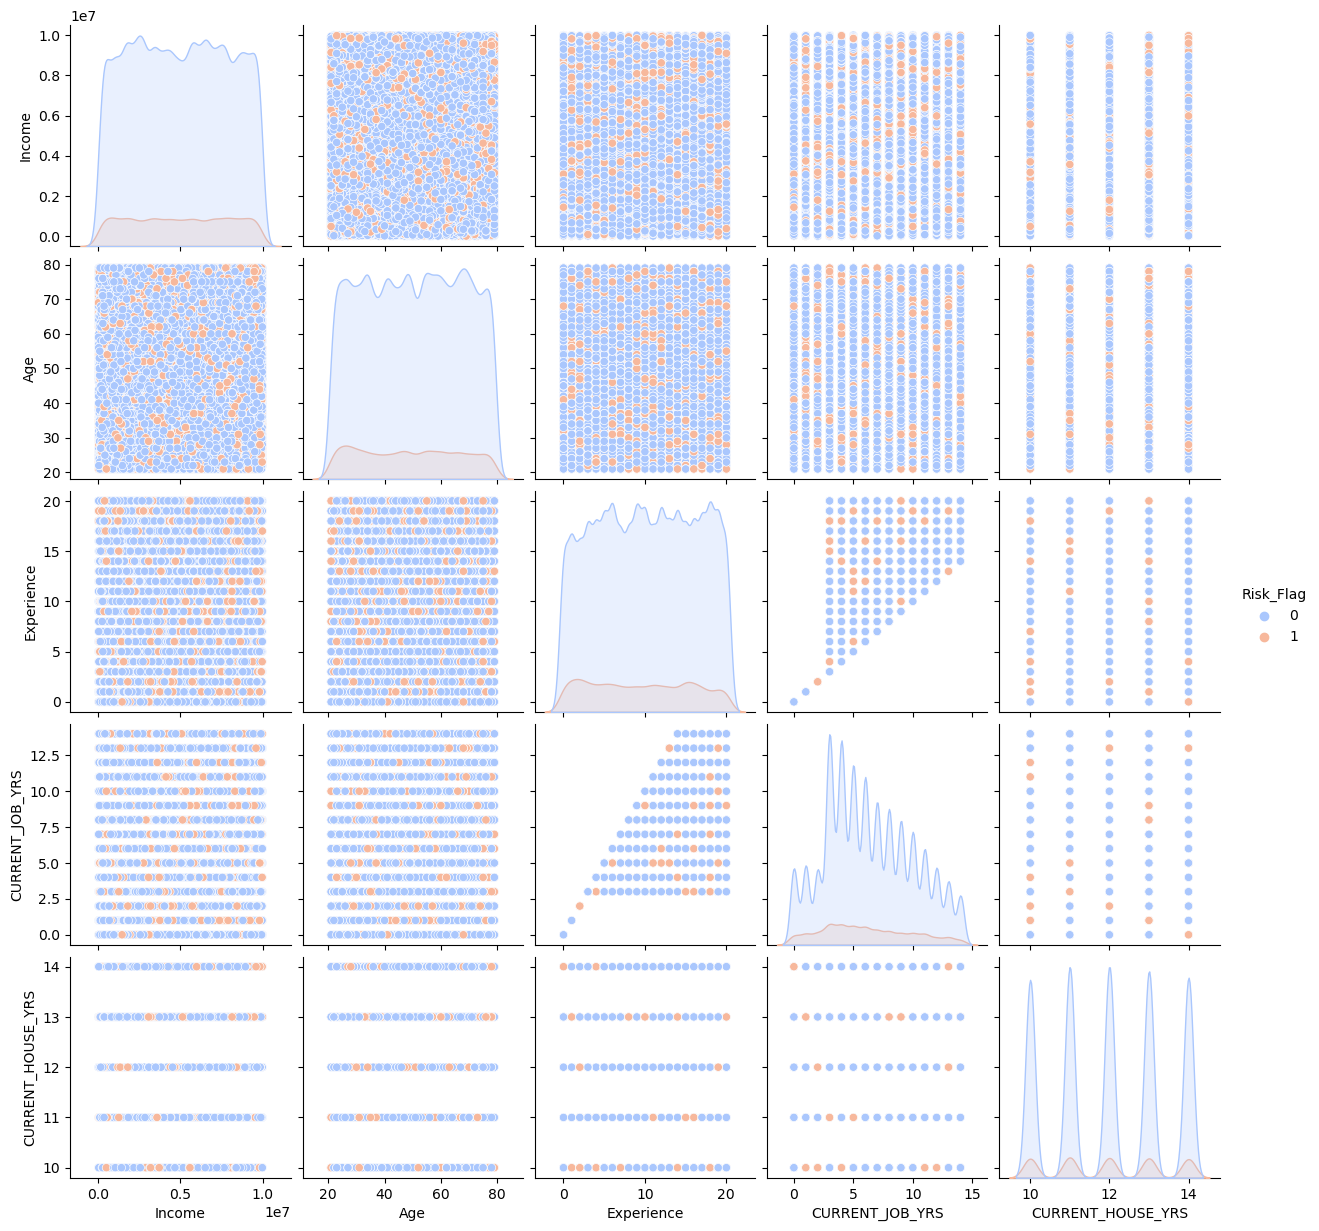

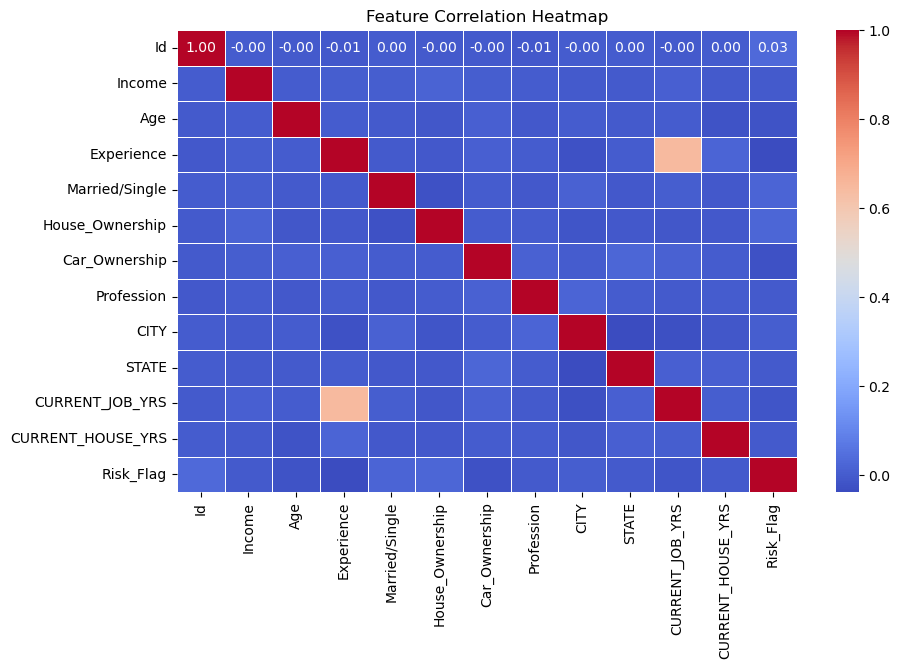

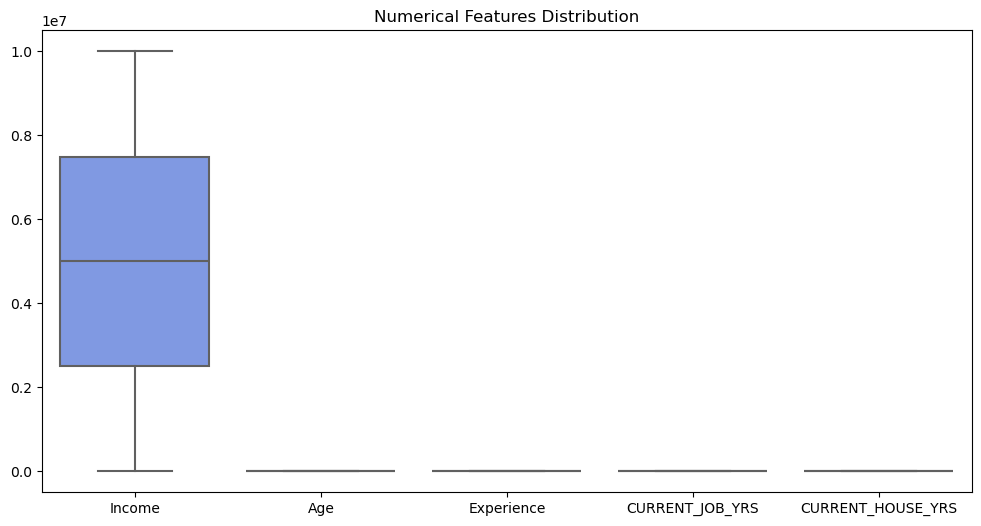

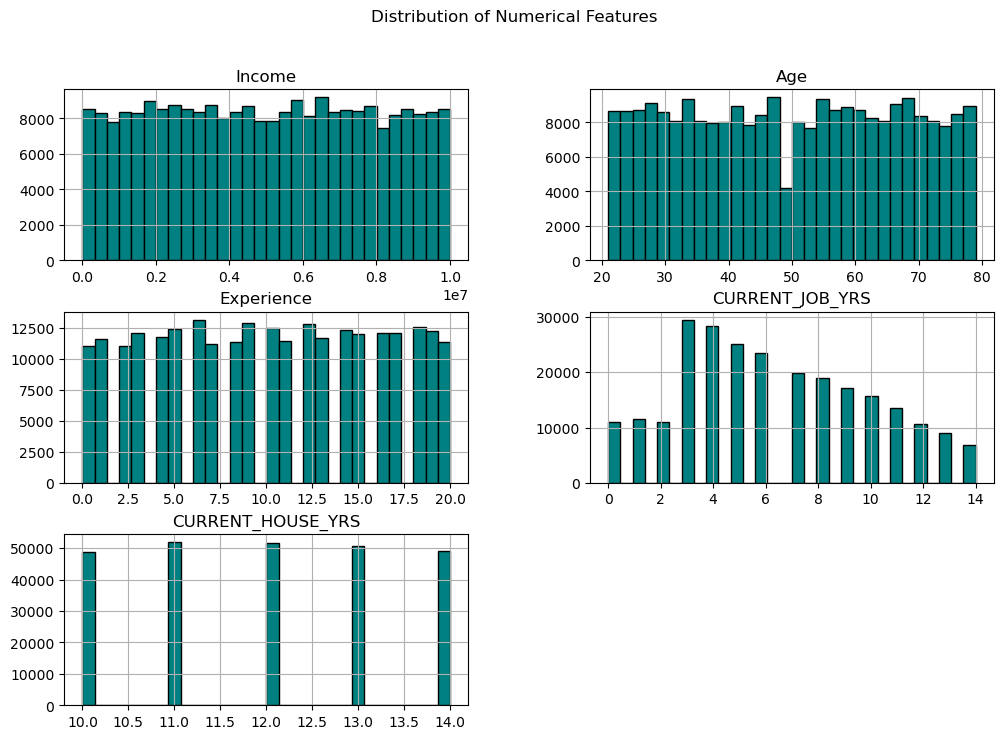

<Figure size 1200x600 with 0 Axes>

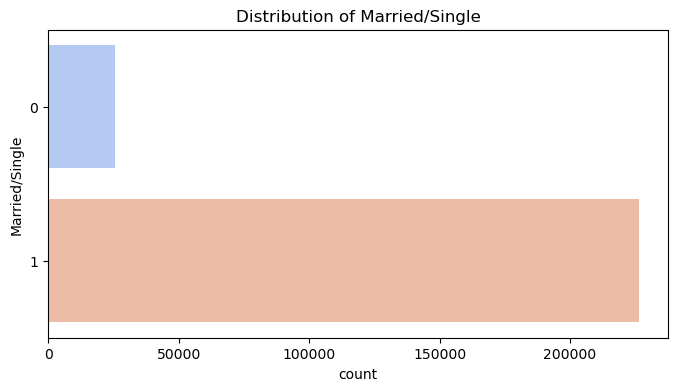

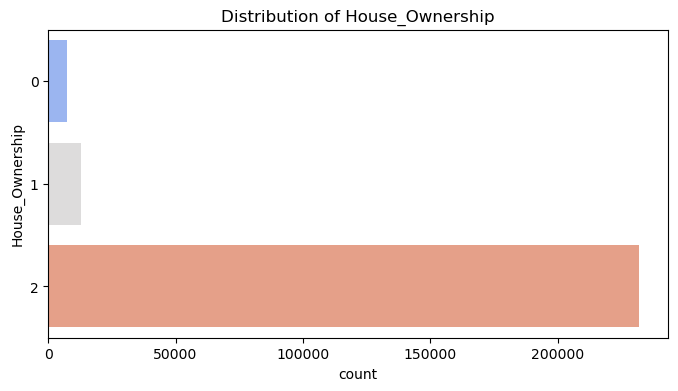

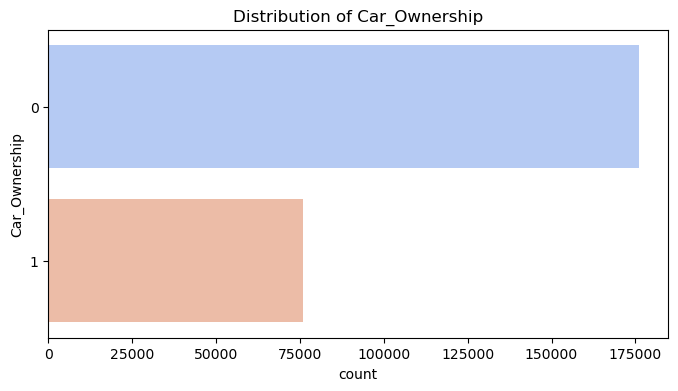

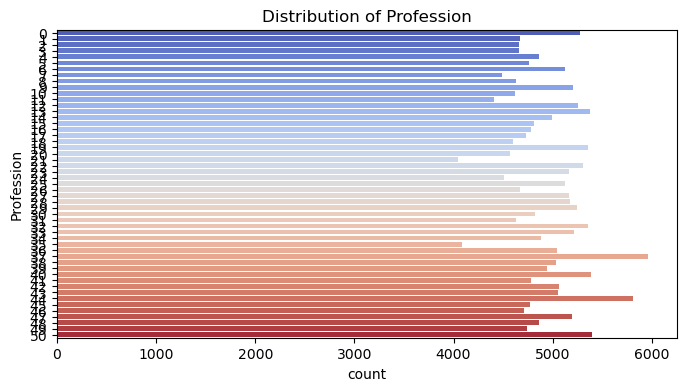

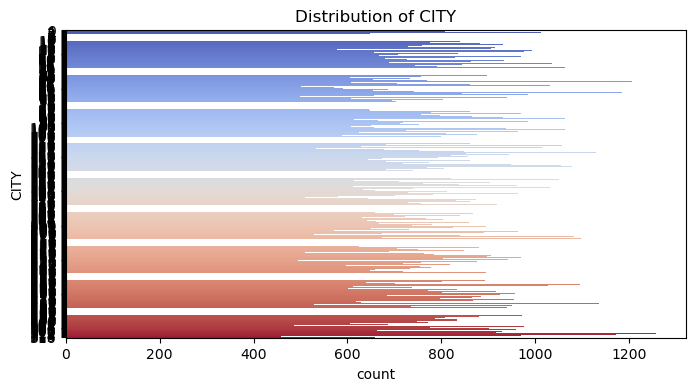

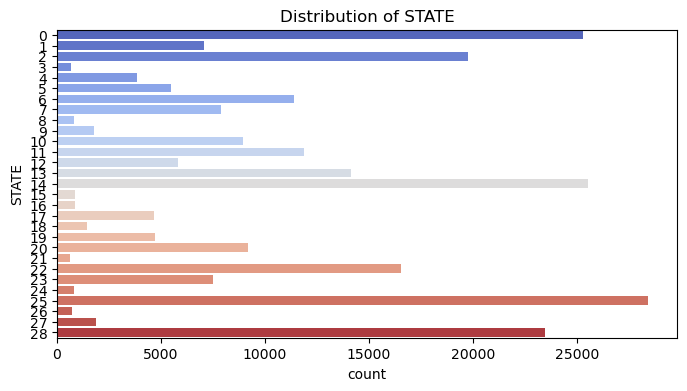

In [22]:
# Exploratory Data Analysis (EDA) & Visualization
plt.figure(figsize=(12, 6))
sns.countplot(x=y, palette='coolwarm')
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Approval Status (0: Approved, 1: Denied)")
plt.ylabel("Count")
plt.show()

# Pairplot to check relationships
sns.pairplot(df[numerical_cols + ['Risk_Flag']], hue='Risk_Flag', palette='coolwarm')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot to check outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_cols], palette='coolwarm')
plt.title("Numerical Features Distribution")
plt.show()

# Histogram for numerical columns
df[numerical_cols].hist(figsize=(12, 8), bins=30, color='teal', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Categorical Data Visualization
plt.figure(figsize=(12, 6))
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df[col], palette='coolwarm')
    plt.title(f"Distribution of {col}")
    plt.show()

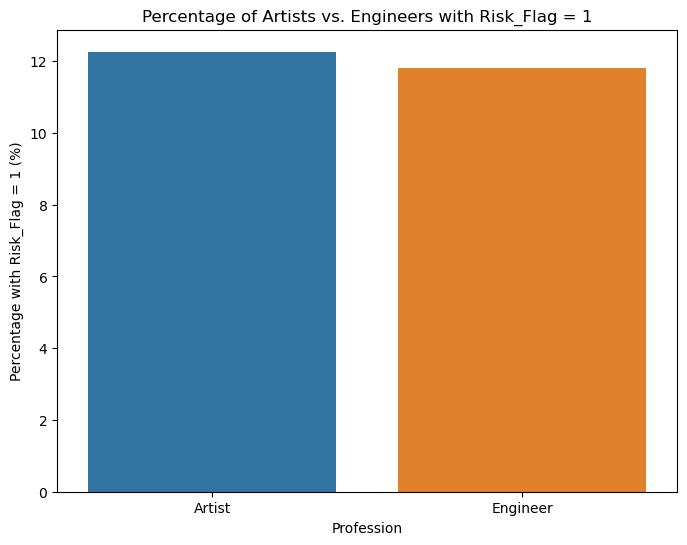

In [18]:
# Filter the DataFrame for Artists and Engineers
filtered_df = df[df['Profession'].isin([le_dict['Profession'].transform(['Artist'])[0],
                                         le_dict['Profession'].transform(['Engineer'])[0]])]

# Calculate the percentage of Risk_Flag = 1 for each profession
profession_risk_percentage = filtered_df.groupby('Profession')['Risk_Flag'].mean() * 100

# Get the original profession labels using the stored encoder
profession_labels = [original_categories['Profession'][p] for p in profession_risk_percentage.index]

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=profession_labels, y=profession_risk_percentage.values)
plt.title("Percentage of Artists vs. Engineers with Risk_Flag = 1")
plt.ylabel("Percentage with Risk_Flag = 1 (%)")
plt.xlabel("Profession")
plt.show()

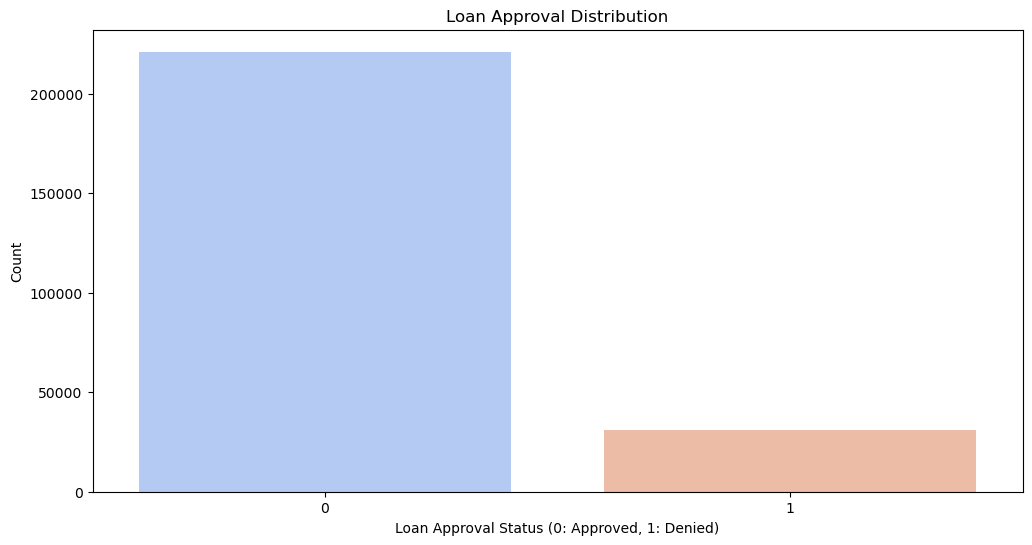

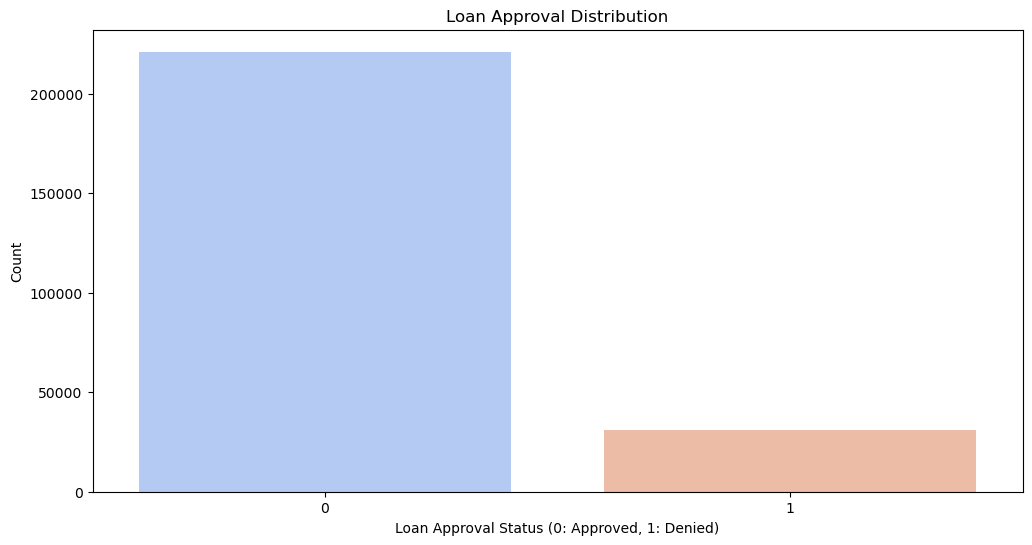

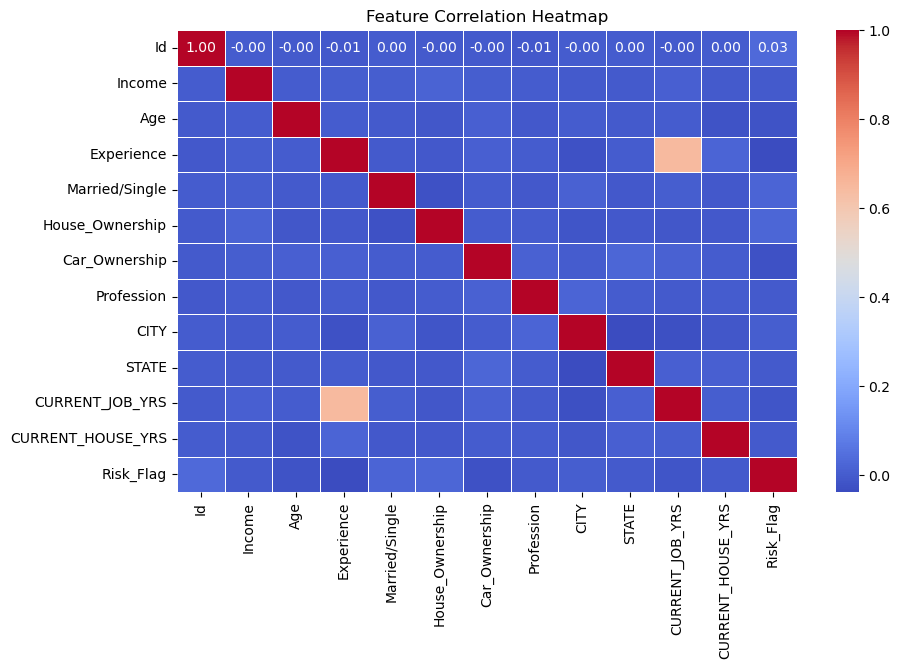

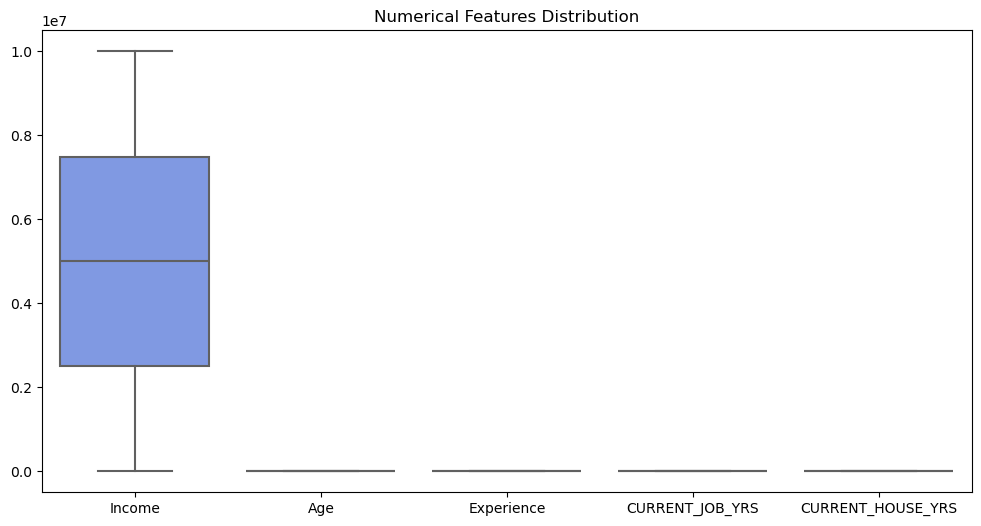

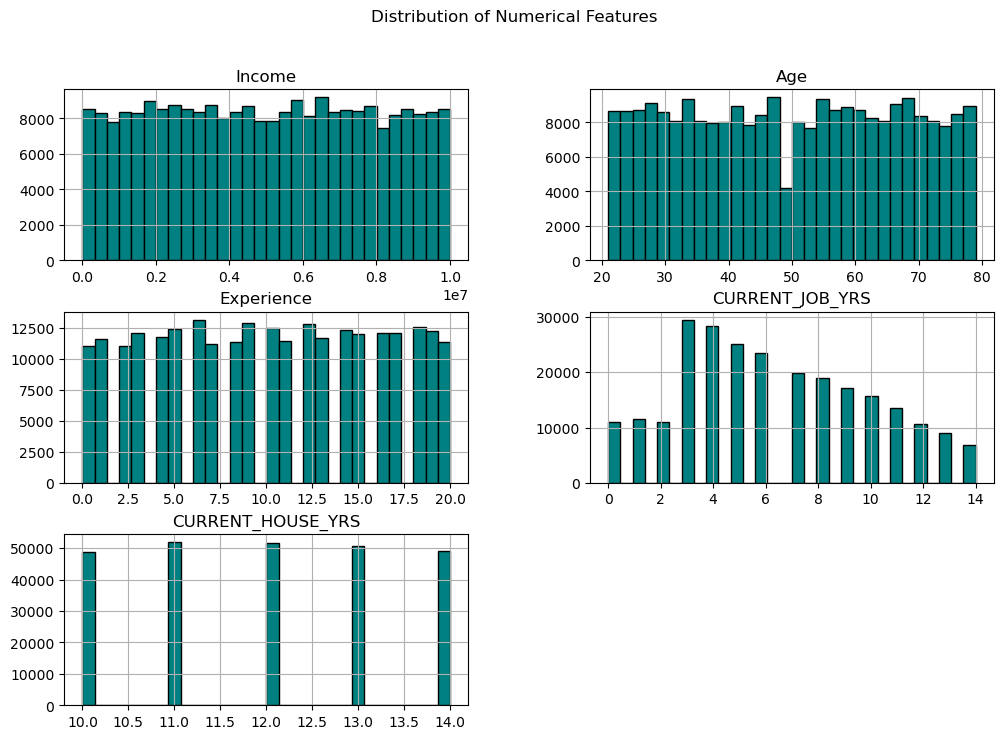

<Figure size 1200x600 with 0 Axes>

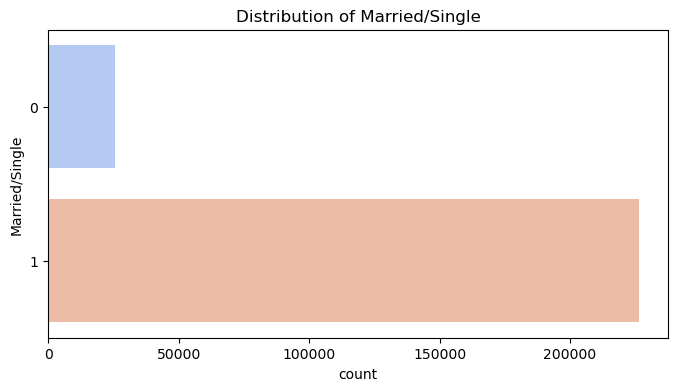

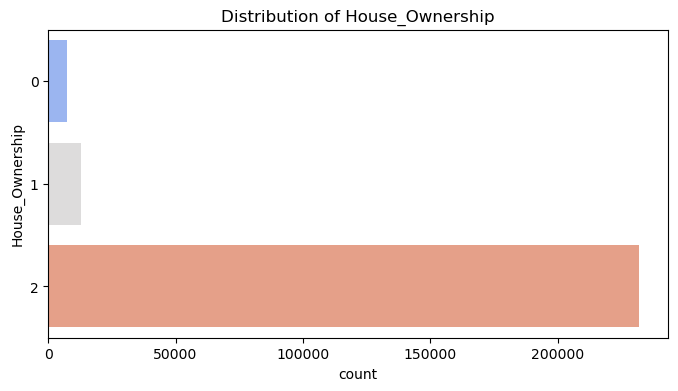

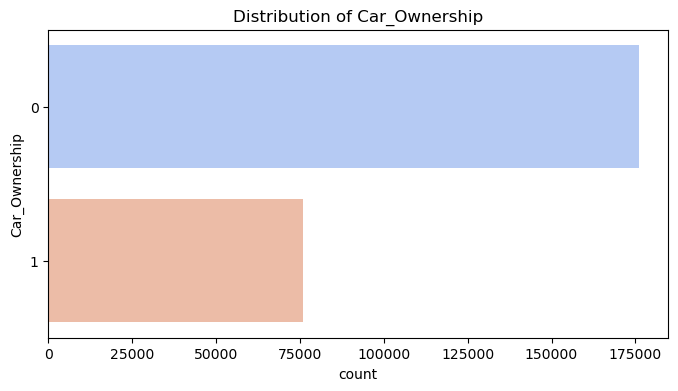

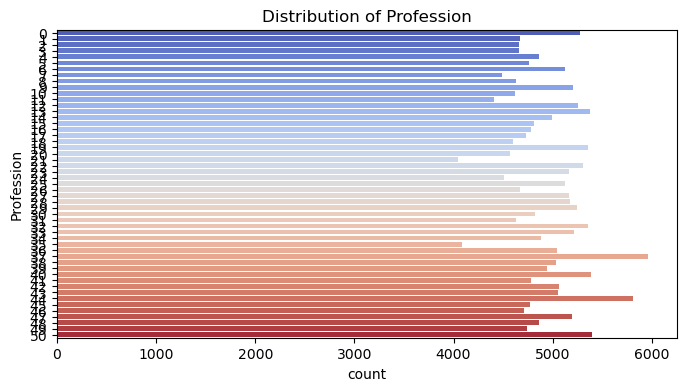

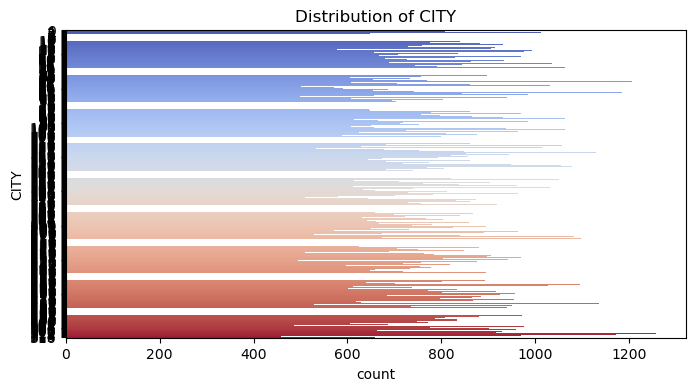

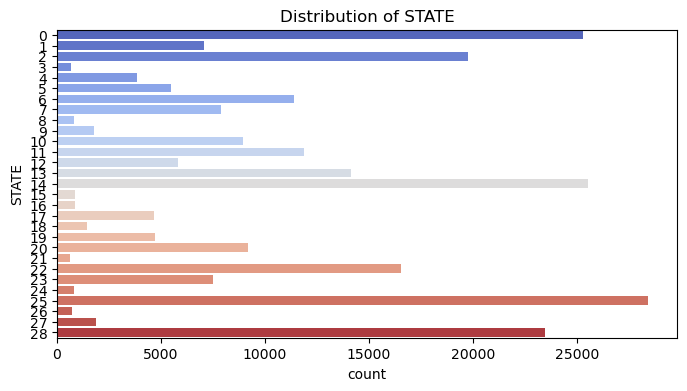

In [20]:
# Select features and target before EDA
X = df.drop(columns=['Id', 'Risk_Flag', 'CITY', 'STATE'], errors='ignore')
y = df['Risk_Flag']  # Define y here

plt.figure(figsize=(12, 6))
sns.countplot(x=y, palette='coolwarm') # Now y is defined
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Approval Status (0: Approved, 1: Denied)")
plt.ylabel("Count")
plt.show()

# Exploratory Data Analysis (EDA) & Visualization
plt.figure(figsize=(12, 6))
sns.countplot(x=y, palette='coolwarm')
plt.title("Loan Approval Distribution")
plt.xlabel("Loan Approval Status (0: Approved, 1: Denied)")
plt.ylabel("Count")
plt.show()


# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot to check outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_cols], palette='coolwarm')
plt.title("Numerical Features Distribution")
plt.show()

# Histogram for numerical columns
df[numerical_cols].hist(figsize=(12, 8), bins=30, color='teal', edgecolor='black')
plt.suptitle("Distribution of Numerical Features")
plt.show()

# Categorical Data Visualization
plt.figure(figsize=(12, 6))
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df[col], palette='coolwarm')
    plt.title(f"Distribution of {col}")
    plt.show()

In [11]:
# Select features and target
X = df.drop(columns=['Id', 'Risk_Flag', 'CITY', 'STATE'], errors='ignore')
y = df['Risk_Flag']

In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Model: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    print("-" * 50)

Model: Logistic Regression
Accuracy: 0.8770039682539682
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     44201
           1       0.00      0.00      0.00      6199

    accuracy                           0.88     50400
   macro avg       0.44      0.50      0.47     50400
weighted avg       0.77      0.88      0.82     50400

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.8789087301587302
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     44201
           1       0.51      0.57      0.54      6199

    accuracy                           0.88     50400
   macro avg       0.72      0.75      0.73     50400
weighted avg       0.89      0.88      0.88     50400

--------------------------------------------------
Model: Random Forest
Accuracy: 0.8971230158730159
              precision    recall  f1-score   support

           0       0.94      0.95

In [ ]:
!pip install imblearn

In [17]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Output class distribution before and after SMOTE
original_distribution = y_train.value_counts().to_dict()
resampled_distribution = pd.Series(y_train_resampled).value_counts().to_dict()

original_distribution, resampled_distribution

({0: 176803, 1: 24797}, {0: 176803, 1: 176803})

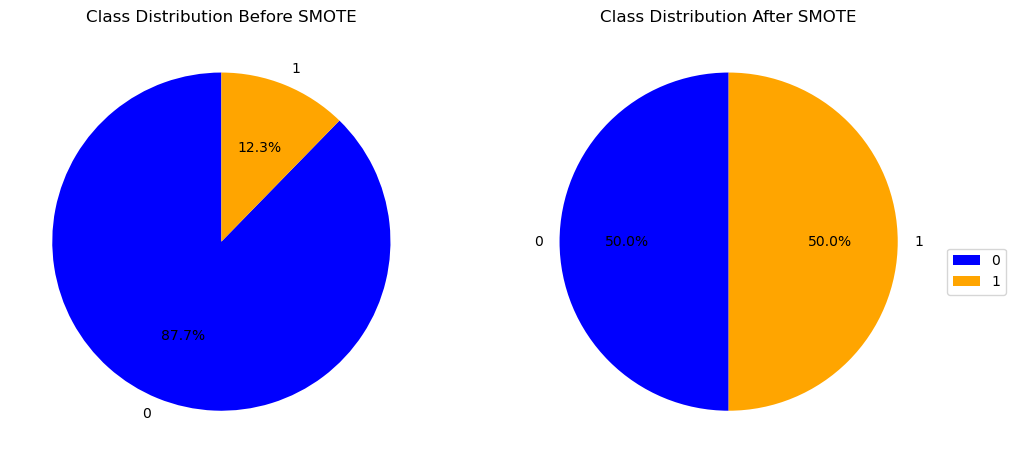

In [19]:
# Create subplots for the two pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Define colors
colors = ['blue', 'orange']

# Pie chart for original distribution
ax1.pie(original_distribution.values(), labels=original_distribution.keys(), autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Class Distribution Before SMOTE')

# Pie chart for resampled distribution
ax2.pie(resampled_distribution.values(), labels=resampled_distribution.keys(), autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Class Distribution After SMOTE')

# Add a legend
plt.legend(original_distribution.keys(), loc="best", bbox_to_anchor=(1, 0.5))

# Display the pie charts
plt.show()

In [21]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)


Model: Logistic Regression
Accuracy: 0.6450
ROC-AUC: 0.5005
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.69      0.77     44201
           1       0.12      0.31      0.18      6199

    accuracy                           0.65     50400
   macro avg       0.50      0.50      0.48     50400
weighted avg       0.78      0.65      0.70     50400

Confusion Matrix:
 [[30595 13606]
 [ 4285  1914]]
------------------------------------------------------------
Model: Decision Tree
Accuracy: 0.8598
ROC-AUC: 0.8592
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91     44201
           1       0.46      0.86      0.60      6199

    accuracy                           0.86     50400
   macro avg       0.72      0.86      0.76     50400
weighted avg       0.91      0.86      0.88     50400

Confusion Matrix:
 [[38011  6190]
 [  878  5321]]
-----------------------

In [23]:
# Ensure the directory for saving the models exists
model_folder = 'model_files'
os.makedirs(model_folder, exist_ok=True)

# Save the trained models
joblib.dump(models['XGBoost'], os.path.join(model_folder, 'xgboost_model.pkl'))
joblib.dump(models['Random Forest'], os.path.join(model_folder, 'random_forest_model.pkl'))
joblib.dump(models['Logistic Regression'], os.path.join(model_folder, 'logistic_regression_model.pkl'))

# Save the label encoders (this is a dictionary of encoders)
joblib.dump(le_dict, os.path.join(model_folder, 'label_encoders.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(model_folder, 'scaler.pkl'))

['model_files\\scaler.pkl']

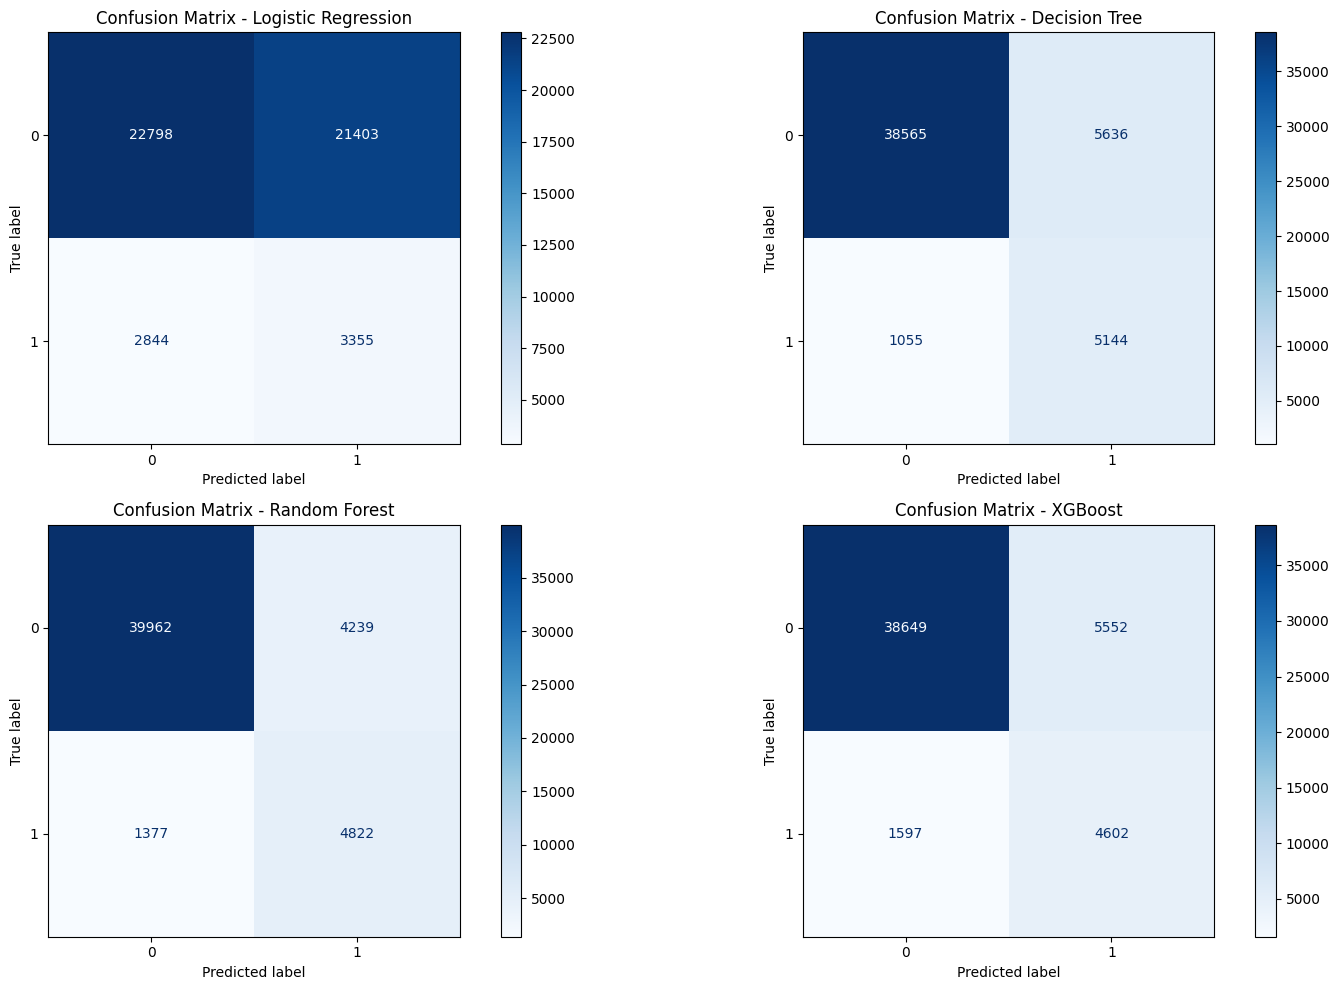

In [54]:
plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(2, 2, i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

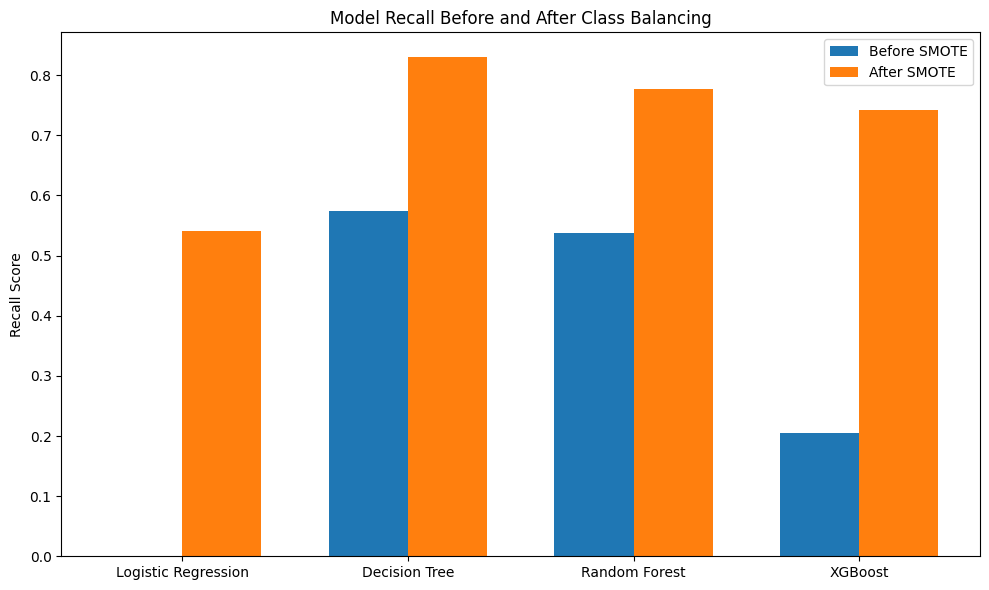

In [53]:
from sklearn.metrics import recall_score
# Store recall scores before and after SMOTE
before_smote_recall = {}
after_smote_recall = {}

# Calculate recall before SMOTE
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)  # Calculate recall
    before_smote_recall[name] = recall

# Calculate recall after SMOTE
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)  # Train on resampled data
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    after_smote_recall[name] = recall

# Plotting the recall scores
model_names = list(models.keys())
before_recall_values = list(before_smote_recall.values())
after_recall_values = list(after_smote_recall.values())

# Explicitly set Logistic Regression recall to 0.00 before SMOTE
before_recall_values = [0.00 if name == 'Logistic Regression' else before_smote_recall.get(name, 0.00) for name in model_names]

after_recall_values = list(after_smote_recall.values())

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width / 2, before_recall_values, width, label='Before SMOTE')
rects2 = ax.bar(x + width / 2, after_recall_values, width, label='After SMOTE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recall Score')
ax.set_title('Model Recall Before and After Class Balancing')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

fig.tight_layout()
plt.show()


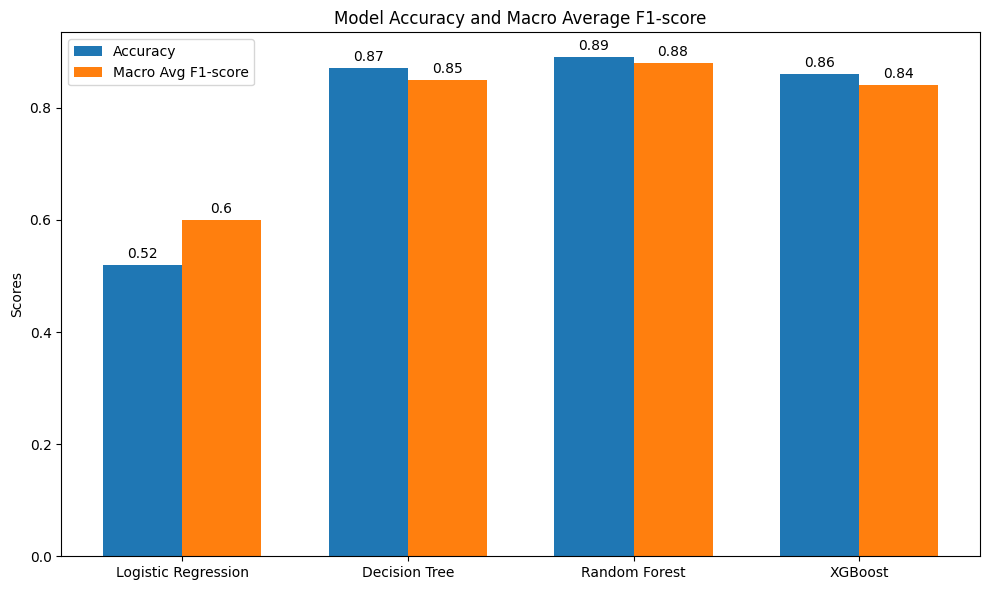

In [ ]:
#plot accuracy and macro avg
results = {
    'Logistic Regression': {'accuracy': 0.52, 'classification_report': {'macro avg': {'f1-score': 0.60}}},
    'Decision Tree': {'accuracy': 0.87, 'classification_report': {'macro avg': {'f1-score': 0.85}}},
    'Random Forest': {'accuracy': 0.89, 'classification_report': {'macro avg': {'f1-score': 0.88}}},
    'XGBoost': {'accuracy': 0.86, 'classification_report': {'macro avg': {'f1-score': 0.84}}},
}

# Extract accuracy and macro average f1-score from classification reports
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]

# Updated logic for extracting f1-score from the classification report
macro_avg_f1_scores = [results[model]['classification_report']['macro avg']['f1-score'] for model in model_names]

# Plotting the bar chart
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, macro_avg_f1_scores, width, label='Macro Avg F1-score')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Accuracy and Macro Average F1-score')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Add labels above bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

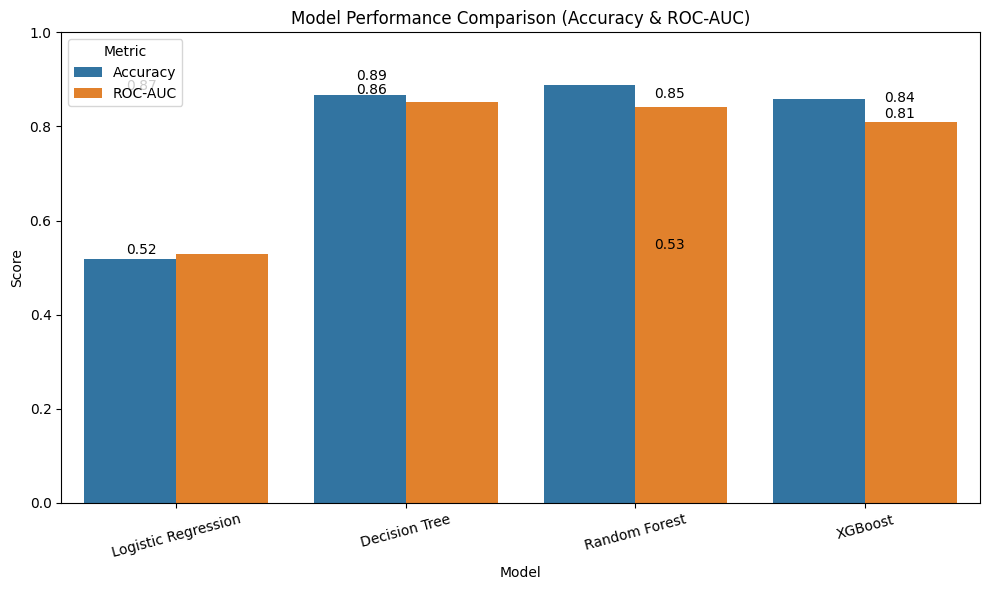

In [ ]:
# Collect model metrics: Accuracy and AUC
model_names = []
accuracies = []
auc_scores = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    model_names.append(name)
    accuracies.append(acc)
    auc_scores.append(auc)

# Create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'ROC-AUC': auc_scores
})

# Melt for easier plotting
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric')
plt.title("Model Performance Comparison (Accuracy & ROC-AUC)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric")
plt.xticks(rotation=15)

# Add score labels
for i in range(len(metrics_melted)):
    plt.text(
        x=i // 2 + (0.15 if metrics_melted['Metric'][i] == 'ROC-AUC' else -0.15),
        y=metrics_melted['Score'][i] + 0.01,
        s=f"{metrics_melted['Score'][i]:.2f}",
        ha='center'
    )

plt.tight_layout()
plt.show()


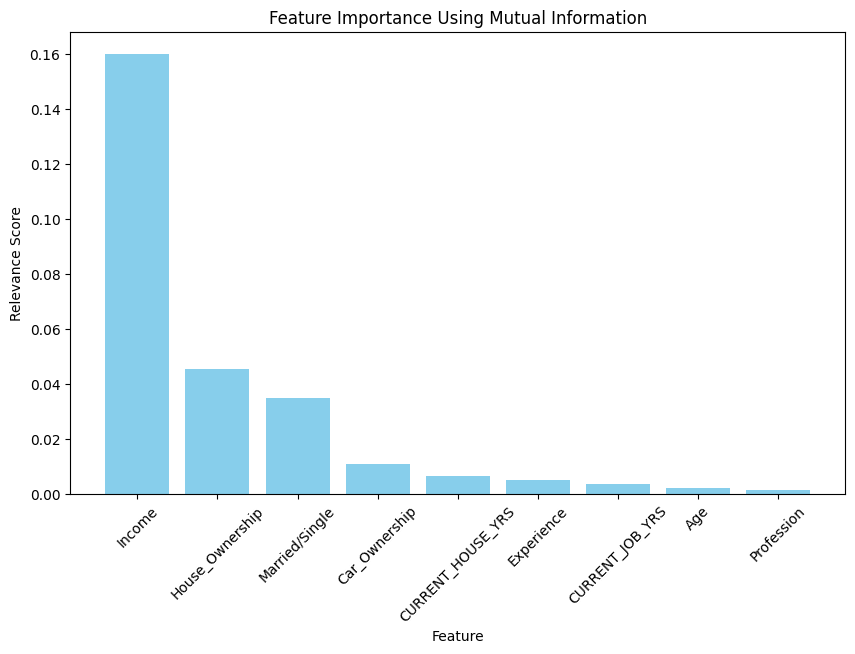

In [ ]:
from sklearn.feature_selection import mutual_info_classif
# Apply Mutual Information Feature Selection
feature_importance = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Relevance': feature_importance
}).sort_values(by='Relevance', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Relevance'], color='skyblue')
plt.xlabel("Feature")
plt.ylabel("Relevance Score")
plt.title("Feature Importance Using Mutual Information")
plt.xticks(rotation=45)
plt.show()

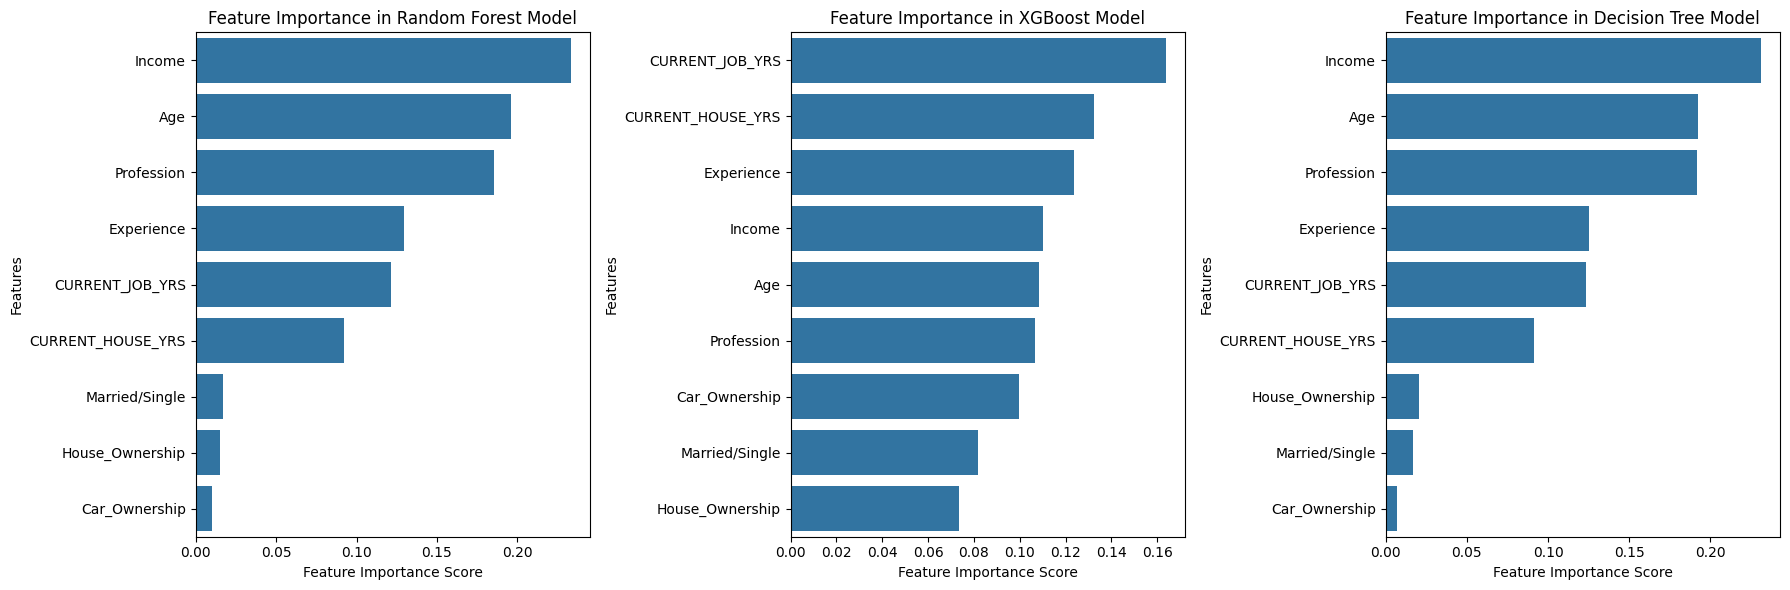

In [ ]:
plt.figure(figsize=(18, 6))

for i, model_name in enumerate(['Random Forest', 'XGBoost', 'Decision Tree']):
    feature_importances = models[model_name].feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.subplot(1, 3, i + 1)  # 1 row, 3 columns
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f"Feature Importance in {model_name} Model")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")

plt.tight_layout()
plt.show()

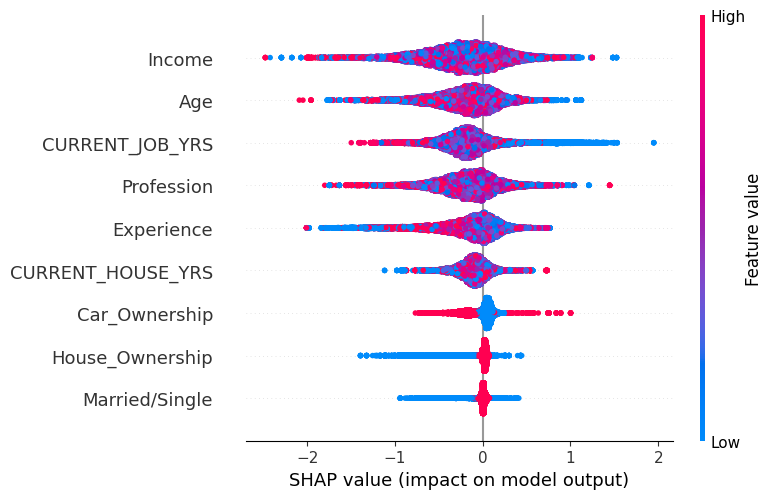

In [ ]:
xgb_classifier = models["XGBoost"]

# Create the SHAP explainer for XGBoost using the trained model
explainer = shap.TreeExplainer(xgb_classifier)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Create a compact summary plot
shap.summary_plot(shap_values, X_test,
                 plot_type="dot",  # Use "dot" for compact plot
                 feature_names=feature_names,
                 max_display=10,  # Limit to top 10 features
                 show=False)

# 5. Show the plot
plt.show()

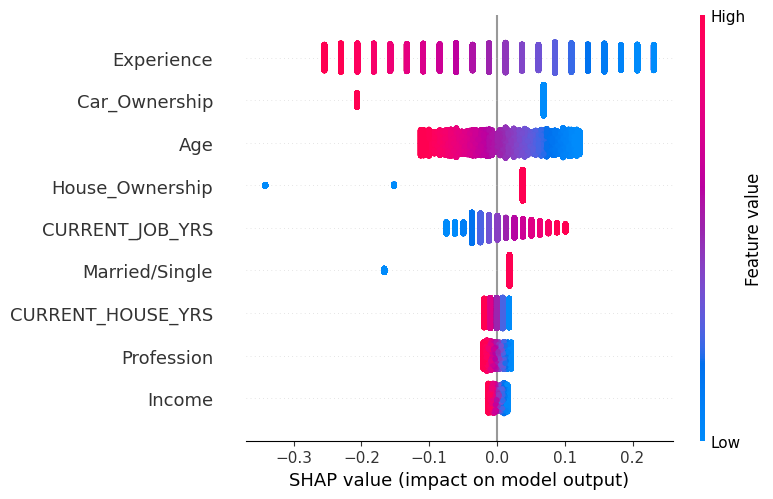

In [46]:
# Get the trained Logistic Regression model
lr_model = models["Logistic Regression"]

# Create the SHAP explainer
explainer = shap.Explainer(lr_model, X_train)
feature_names = X_train.columns
# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test) # Assuming X_test is preprocessed if necessary

# Create a compact summary plot
shap.summary_plot(shap_values, X_test,
                 plot_type="dot",
                 feature_names=feature_names,
                 max_display=10,
                 show=False)

# Save the plot to a file
plt.savefig("shap_summary_lr.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
import os
import joblib

# Ensure the directory for saving the models exists
model_folder = 'model_files'
os.makedirs(model_folder, exist_ok=True)

# Save the trained models
joblib.dump(models['XGBoost'], os.path.join(model_folder, 'xgboost_model.pkl'))
joblib.dump(models['Random Forest'], os.path.join(model_folder, 'random_forest_model.pkl'))
joblib.dump(models['Logistic Regression'], os.path.join(model_folder, 'logistic_regression_model.pkl'))

# Save the label encoders (this is a dictionary of encoders)
joblib.dump(le_dict, os.path.join(model_folder, 'label_encoders.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(model_folder, 'scaler.pkl'))

In [ ]:
import os
import joblib

# Ensure the directory for saving the models exists
model_folder = 'model_files'
os.makedirs(model_folder, exist_ok=True)

# Save the trained models
joblib.dump(models['XGBoost'], os.path.join(model_folder, 'xgboost_model.pkl'))
joblib.dump(models['Random Forest'], os.path.join(model_folder, 'random_forest_model.pkl'))
joblib.dump(models['Logistic Regression'], os.path.join(model_folder, 'logistic_regression_model.pkl'))

# Save the label encoders (this is a dictionary of encoders)
joblib.dump(le_dict, os.path.join(model_folder, 'label_encoders.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join(model_folder, 'scaler.pkl'))